In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit
from scipy.integrate import quad
from pyvbmc import VBMC
import corner
import random
from tqdm import tqdm

from psiam_tied_utils import psiam_tied_data_gen_wrapper, rho_A_t_fn, up_RTs_fit_fn, down_RTs_fit_fn


# params

In [2]:
# stim params
ABL_arr = [20, 40, 60]
ILD_arr = [-6, -3, 0, 3, 6]

# Model params
rate_lambda = 0.076
theta_E = 50.7
T_0 = 0.19*(1e-3)

V_A = 0.5
theta_A = 1

t_stim = 0.25
t_A_aff = 0.02
t_E_aff = 0.03
t_motor = 0.04
Z_E = 0

# sim params
N_sim = int(20e3)
dt = 1e-4

# fitting params
K_max = 10

# gen data

In [3]:
sim_results = Parallel(n_jobs=-1)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr,\
                                                                        rate_lambda, T_0, theta_E, Z_E, \
                                                                            t_stim, t_A_aff, t_E_aff, t_motor, dt)\
                                                                                  for _ in range(N_sim))

# loglike fn

In [4]:
def compute_loglike(res, V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor):
    ILD = res['ILD']
    ABL = res['ABL']
    choice = res['choice']
    rt = res['rt']

    # NOTE: unbiasing starting point for now
    Z_E = 0

    if rt < t_stim:
        likelihood = rho_A_t_fn(rt, V_A, theta_A)
    else:
        if choice == 1:
            likelihood = up_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, \
                                       t_stim, t_A_aff, t_E_aff, t_motor, K_max)[0]
        elif choice == -1:
            likelihood = down_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, \
                                         t_stim, t_A_aff, t_E_aff, t_motor, K_max)[0]


    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    


def psiam_tied_loglike_fn(params):
    V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor = params


    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(res, V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor)\
                                       for res in sim_results)

    loglike = np.sum(all_loglike)
    return loglike

# Bounds

In [9]:
V_A_bounds = [0.2, 1.2]
theta_A_bounds = [0.5, 1.5]

rate_lambda_bounds = [0.01, 0.15]
T_0_bounds = [0.1*(1e-3), 0.8*(1e-3)]
theta_E_bounds = [35, 65]

t_A_aff_bounds = [0.009, 0.07]
t_E_aff_bounds = [0.009, 0.07]
t_motor_bounds = [0.009, 0.07]

# ---
V_A_plausible_bounds = [0.2, 1]
theta_A_plausible_bounds = [0.7, 1.3]

rate_lambda_plausible_bounds =  [0.05, 0.09]
T_0_plausible_bounds = [0.15*(1e-3), 0.3*(1e-3)]
theta_E_plausible_bounds = [40, 55]

t_A_aff_plausible_bounds = [0.01, 0.05]
t_E_aff_plausible_bounds = [0.01, 0.05]
t_motor_plausible_bounds = [0.01, 0.05]

# True
# V_A = 0.5
# theta_A = 1

# rate_lambda = 0.076
# T_0 = 0.19*(1e-3)
# theta_E = 50.7

# t_A_aff = 0.02
# t_E_aff = 0.03
# t_motor = 0.04

# prior

In [6]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def psiam_tied_prior_fn(params):
    V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor = params

    V_A_logpdf = trapezoidal_logpdf(V_A, V_A_bounds[0], V_A_plausible_bounds[0], V_A_plausible_bounds[1], V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    
    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], T_0_plausible_bounds[1], T_0_bounds[1])
    
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    t_motor_logpdf = trapezoidal_logpdf(t_motor, t_motor_bounds[0], t_motor_plausible_bounds[0], t_motor_plausible_bounds[1], t_motor_bounds[1])

    return V_A_logpdf + theta_A_logpdf + rate_lambda_logpdf + theta_E_logpdf + T_0_logpdf + t_A_aff_logpdf + t_E_aff_logpdf + t_motor_logpdf


# prior + loglike

In [7]:
def psiam_tied_joint_fn(params):
    priors = psiam_tied_prior_fn(params) 
    loglike = psiam_tied_loglike_fn(params)

    joint = priors + loglike
    return joint

# run vbmc

In [10]:
lb = np.array([V_A_bounds[0], theta_A_bounds[0], rate_lambda_bounds[0], T_0_bounds[0], theta_E_bounds[0], t_A_aff_bounds[0], t_E_aff_bounds[0], t_motor_bounds[0]])
ub = np.array([V_A_bounds[1], theta_A_bounds[1], rate_lambda_bounds[1], T_0_bounds[1], theta_E_bounds[1], t_A_aff_bounds[1], t_E_aff_bounds[1], t_motor_bounds[1]])
plb = np.array([V_A_plausible_bounds[0], theta_A_plausible_bounds[0], rate_lambda_plausible_bounds[0], T_0_plausible_bounds[0], theta_E_plausible_bounds[0], t_A_aff_plausible_bounds[0], t_E_aff_plausible_bounds[0], t_motor_plausible_bounds[0]])
pub = np.array([V_A_plausible_bounds[1], theta_A_plausible_bounds[1], rate_lambda_plausible_bounds[1], T_0_plausible_bounds[1], theta_E_plausible_bounds[1], t_A_aff_plausible_bounds[1], t_E_aff_plausible_bounds[1], t_motor_plausible_bounds[1]])

np.random.seed(42)
V_A_0 = np.random.uniform(V_A_plausible_bounds[0], V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])
t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
t_motor_0 = np.random.uniform(t_motor_plausible_bounds[0], t_motor_plausible_bounds[1])

x_0 = np.array([V_A_0, theta_A_0, rate_lambda_0, T_0_0, theta_E_0, t_A_aff_0, t_E_aff_0, t_motor_0])

vbmc = VBMC(psiam_tied_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 8).
Reshaping upper bounds to (1, 8).
Reshaping plausible lower bounds to (1, 8).
Reshaping plausible upper bounds to (1, 8).
vbmc:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.


/home/rka/.local/lib/python3.10/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/home/rka/.local/lib/python3.10/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: 11078.900 +/-0.023.


# corner

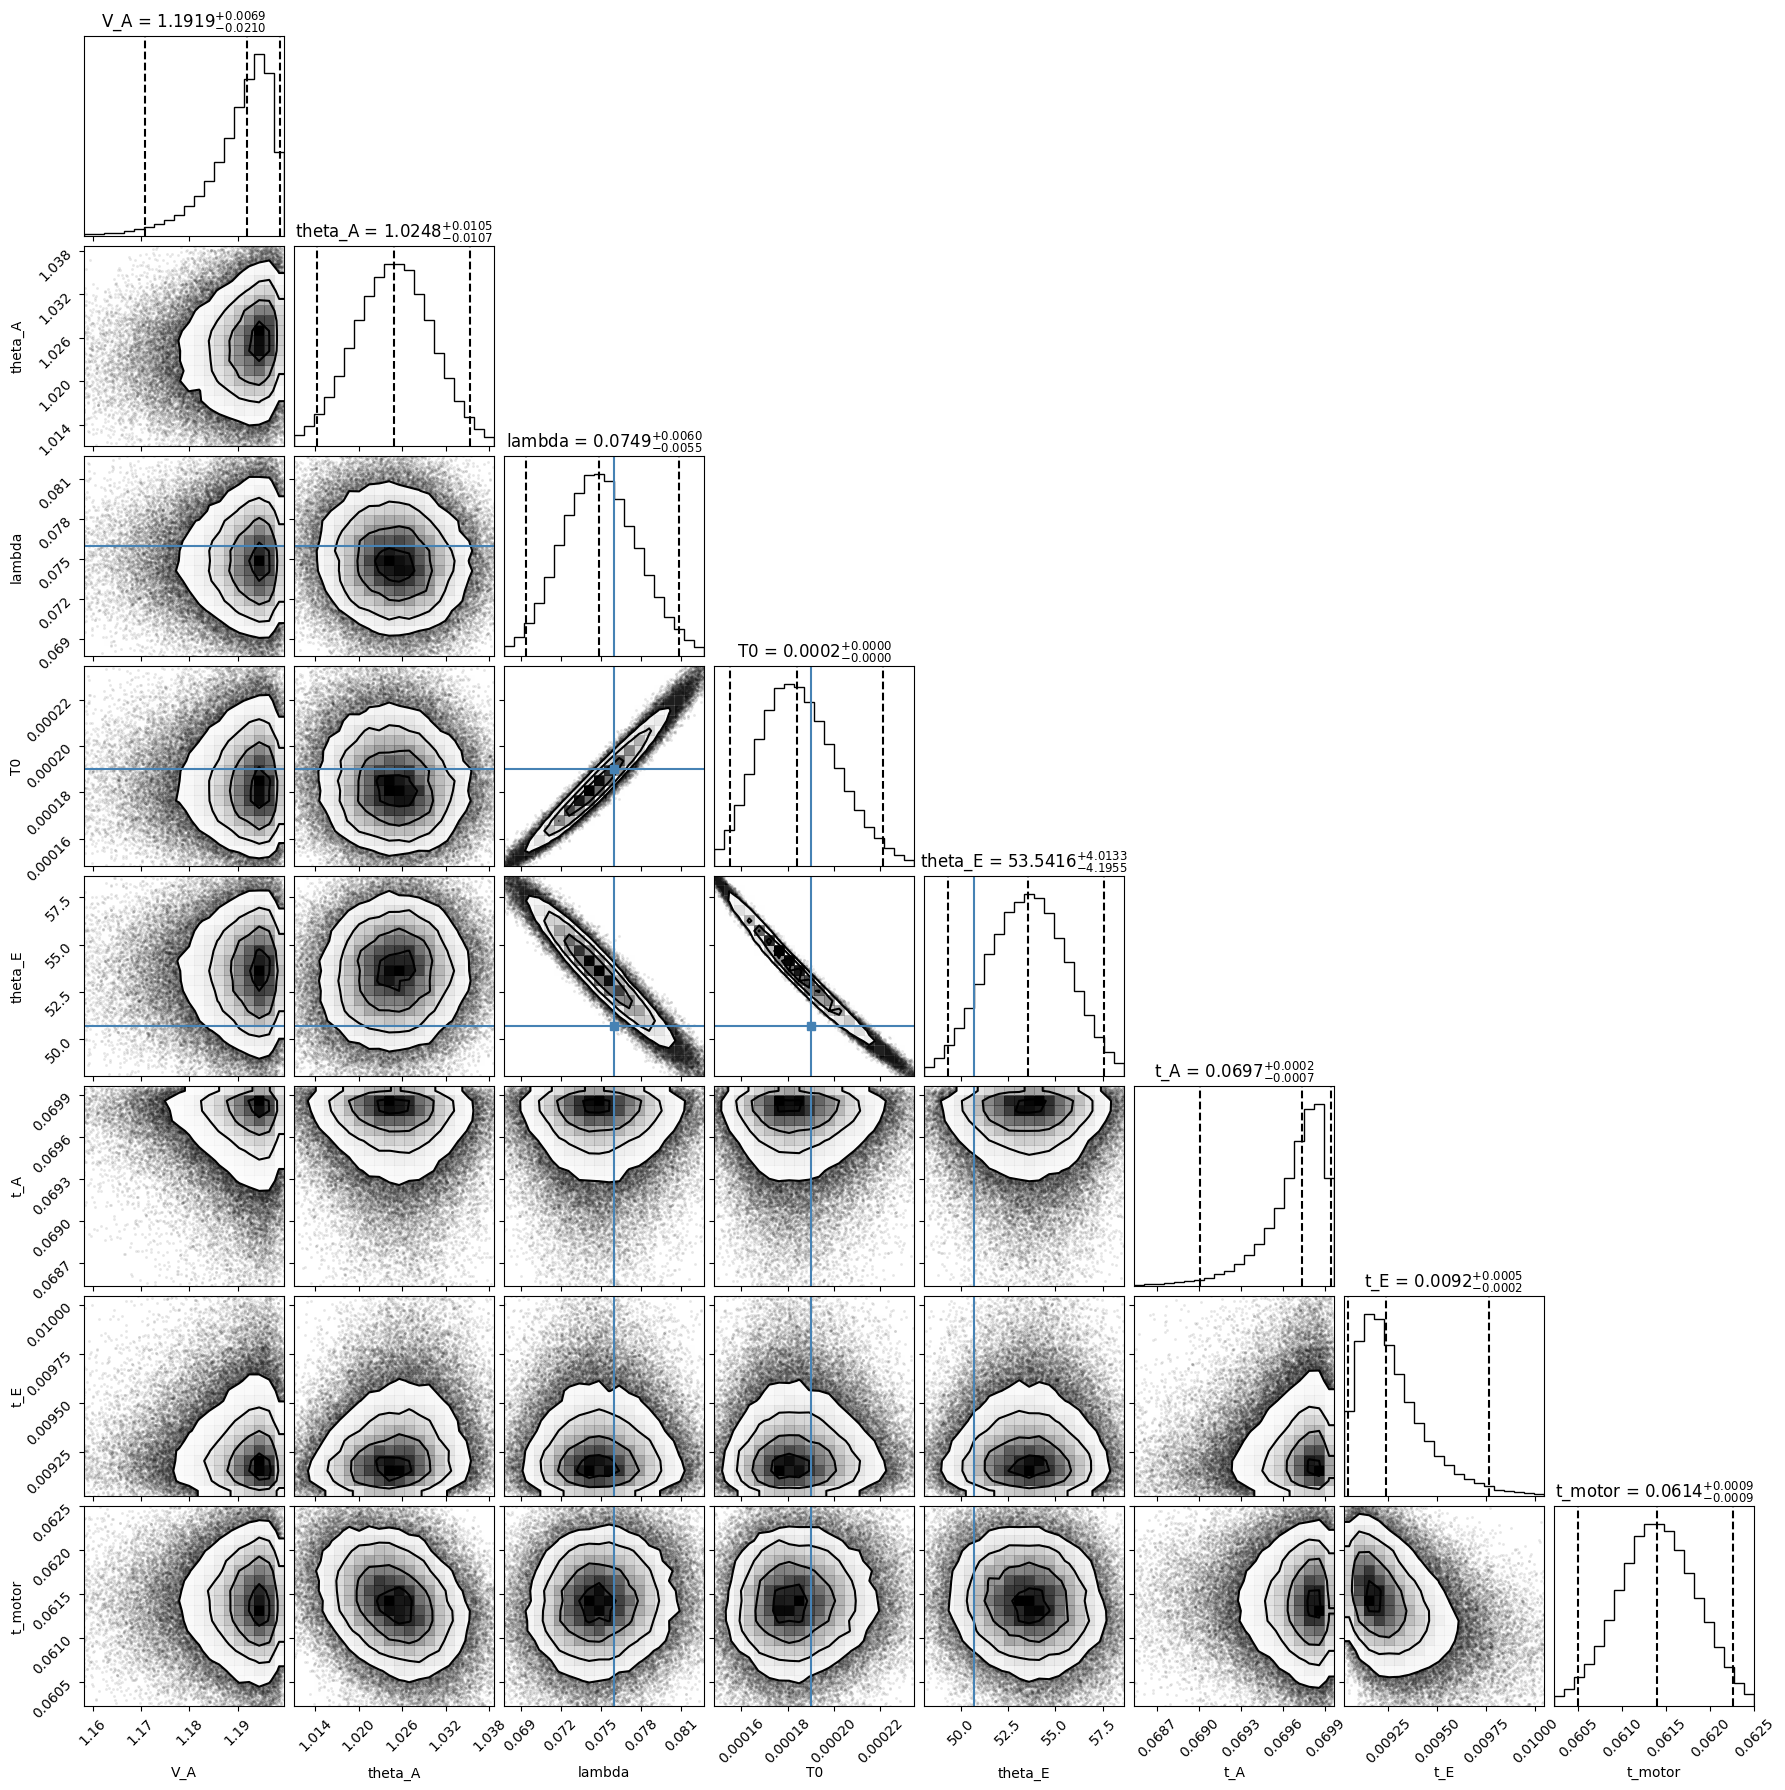

In [11]:
vp_samples = vp.sample(int(1e5))[0]

param_labels = ['V_A', 'theta_A', 'lambda', 'T0', 'theta_E', 't_A', 't_E', 't_motor']
true_arr = [V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor]

percentiles = np.percentile(vp_samples, [0.5, 99.5], axis=0)

_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(vp_samples.shape[1])]


# Now create the corner plot using these ranges
corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    truths=true_arr,
    title_fmt=".4f"
);

# check likelihood

In [20]:
mean_vb_params = {}
for i, label in enumerate(param_labels):
    mean_vb_params[label] = np.mean(vp_samples[:, i])

In [23]:
# likelihood of true params
true_loglike = psiam_tied_loglike_fn([V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor])
# likelihood of mean params
mean_vb_loglike = psiam_tied_loglike_fn([mean_vb_params['V_A'], mean_vb_params['theta_A'], mean_vb_params['lambda'], mean_vb_params['T0'], mean_vb_params['theta_E'], mean_vb_params['t_A'], mean_vb_params['t_E'], mean_vb_params['t_motor']])
print(f"True loglike: {true_loglike/1e3}")
print(f"Mean VB loglike: {mean_vb_loglike/1e3}")

True loglike: 10.338820561462947
Mean VB loglike: 11.11886682902542


# taco curves

/tmp/ipykernel_360542/3773883730.py:11: RuntimeWarning: invalid value encountered in divide
  real_taco = real_up/(real_up + real_down)
/tmp/ipykernel_360542/3773883730.py:15: RuntimeWarning: invalid value encountered in divide
  mean_taco = mean_up/(mean_up + mean_down)


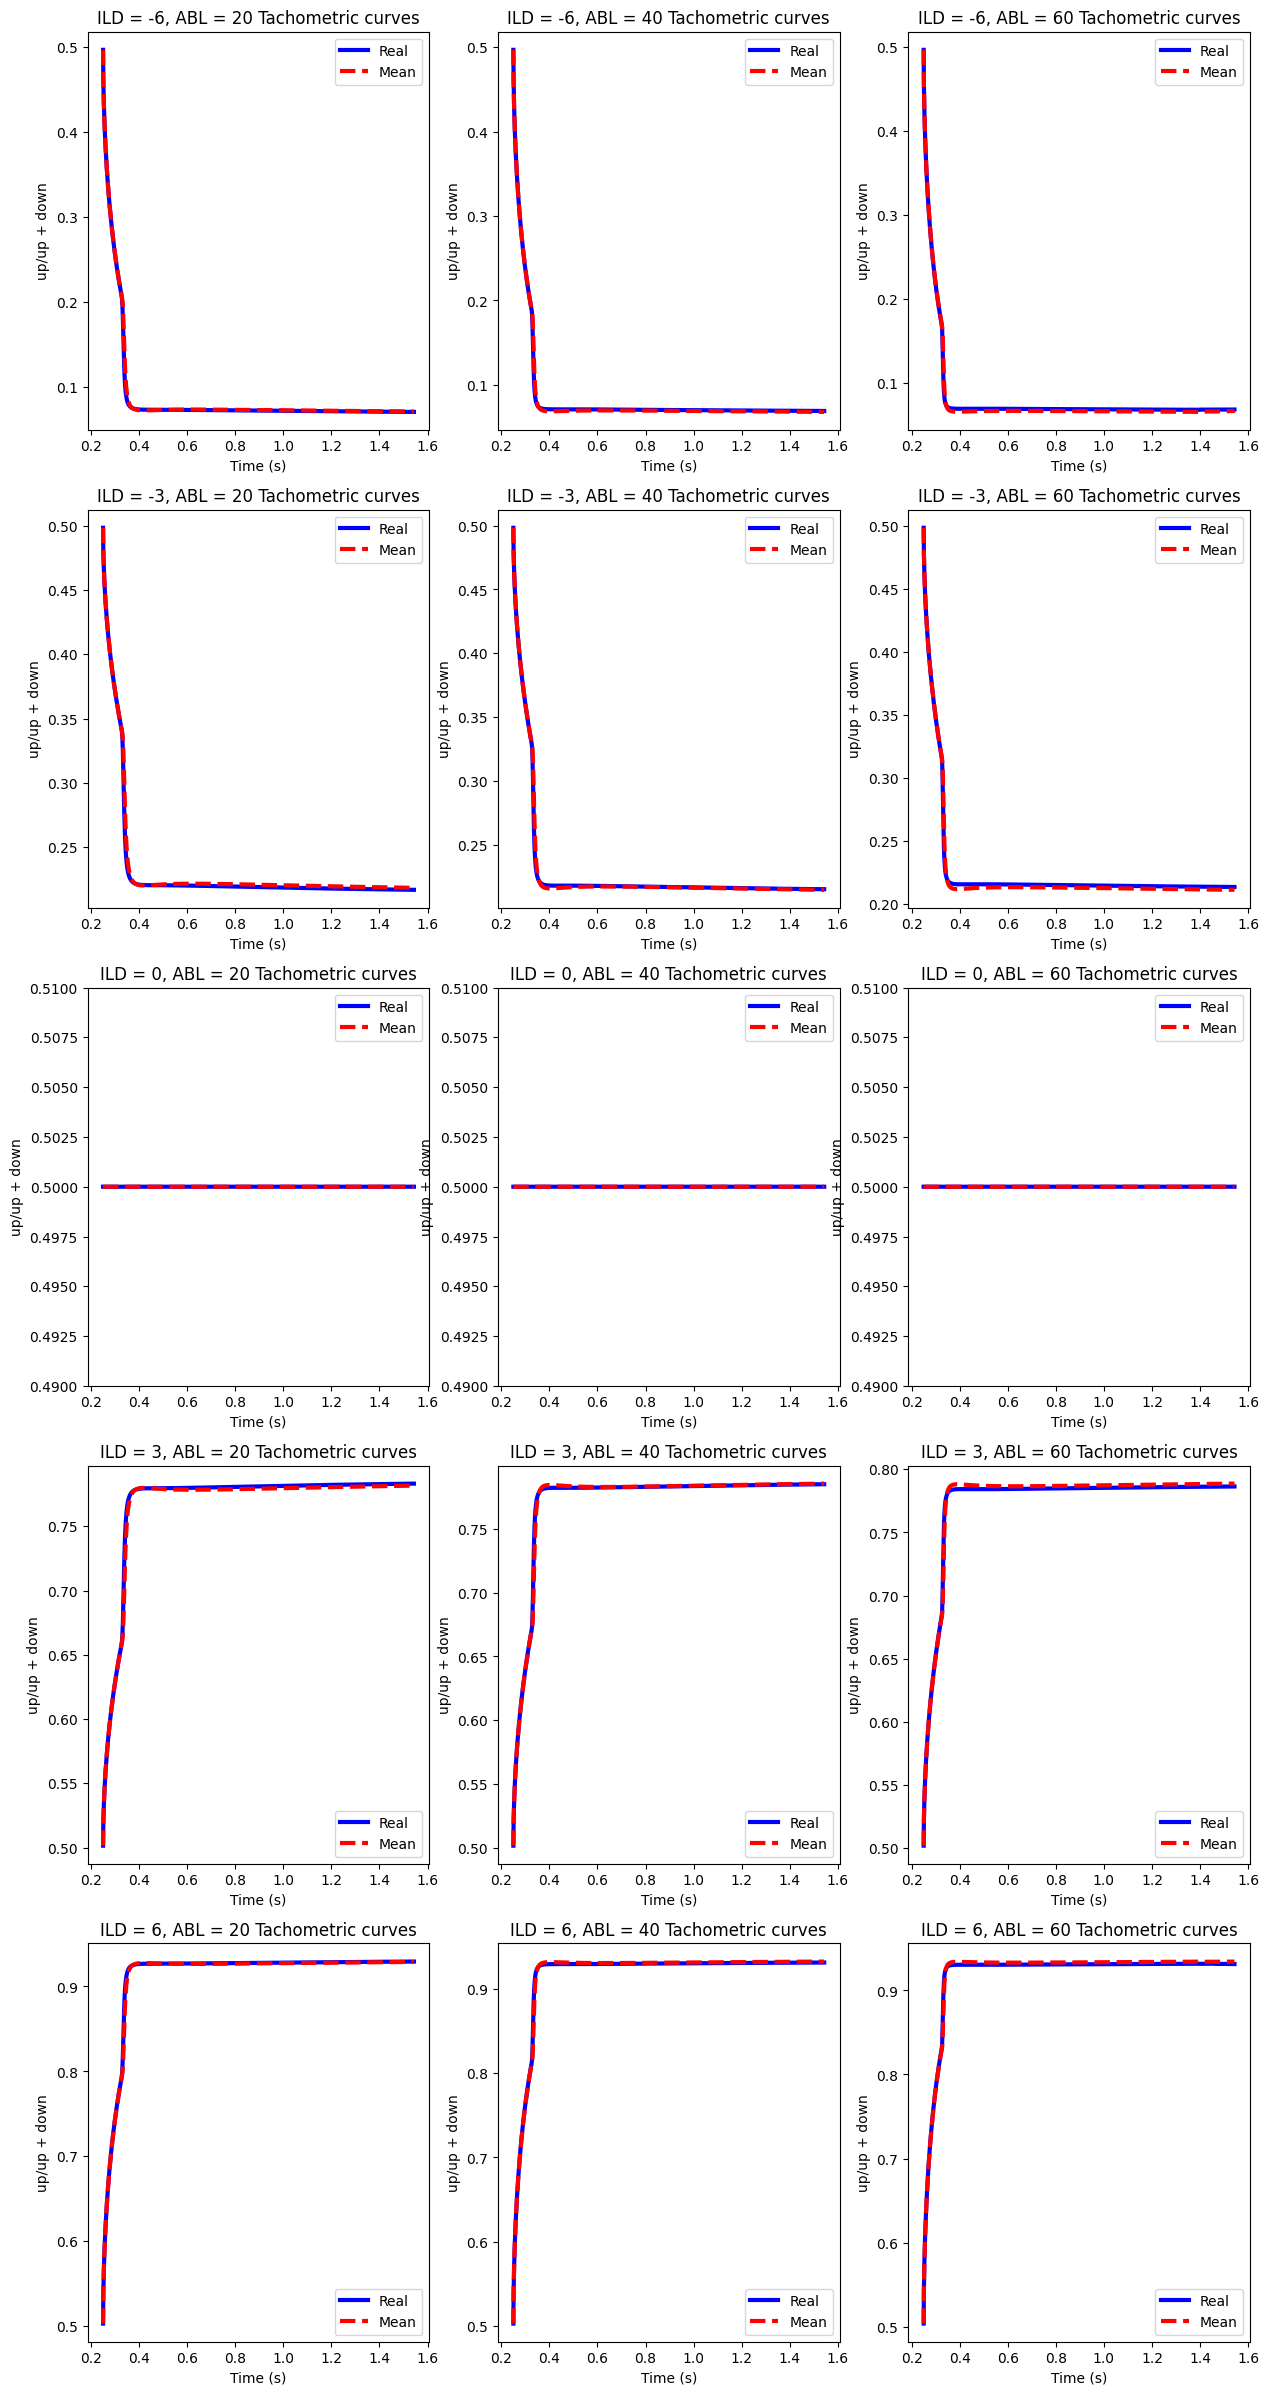

In [47]:
all_rt = [res['rt'] for res in sim_results]
max_all_rt = np.max(all_rt)
t_pts = np.linspace(0.001, max_all_rt, 1500)

plt.figure(figsize=(15, 30))
fig_num = 1
for ILD in ILD_arr:
    for ABL in ABL_arr:
        real_up = up_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)
        real_down = down_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)
        real_taco = real_up/(real_up + real_down)

        mean_up = up_RTs_fit_fn(t_pts, mean_vb_params['V_A'], mean_vb_params['theta_A'], ABL, ILD, mean_vb_params['lambda'], mean_vb_params['T0'], mean_vb_params['theta_E'], Z_E, t_stim, mean_vb_params['t_A'], mean_vb_params['t_E'], mean_vb_params['t_motor'], K_max)
        mean_down = down_RTs_fit_fn(t_pts, mean_vb_params['V_A'], mean_vb_params['theta_A'], ABL, ILD, mean_vb_params['lambda'], mean_vb_params['T0'], mean_vb_params['theta_E'], Z_E, t_stim, mean_vb_params['t_A'], mean_vb_params['t_E'], mean_vb_params['t_motor'], K_max)
        mean_taco = mean_up/(mean_up + mean_down)

        
        plt.subplot(len(ILD_arr),len(ABL_arr),fig_num)
        plt.plot(t_pts, real_taco, label='Real', linestyle='-', color='b', linewidth=3);
        plt.plot(t_pts, mean_taco, label='Mean', linestyle='--', color='r',  linewidth=3);
        plt.legend();
        plt.xlabel('Time (s)');plt.ylabel('up/up + down');plt.title(f'ILD = {ILD}, ABL = {ABL} Tachometric curves');

        # plt.xlim([0.1, 2])
        # plt.ylim([np.nanmean(real_taco) - 1e-2, np.nanmean(real_taco) + 1e-2])
        if ILD == 0:
            plt.ylim([0.49, 0.51])

        fig_num += 1
